Project Background and Problem Definition

In today's real estate market, house prices are influenced by various factors, including location, house size, age, number of rooms, and building structure. Accurate price prediction is valuable not only for homebuyers and investors but also for real estate agencies and financial institutions, providing a basis for pricing and risk assessment.

This project focuses on the problem of "predicting second-hand house prices," aiming to build a regression model to predict the market price of second-hand houses based on historical data. By identifying key features that influence house prices and building multiple machine learning models, we aim to achieve a balance between prediction accuracy, model interpretability, and generalization capability.

The core problem definition of this task is as follows:

Problem Statement: Predict the market sale price of houses based on their structural and location attributes.
Modeling Goal: Select appropriate features and algorithms to build a price prediction model, and evaluate the model's performance using suitable metrics.
Business Significance: Assist real estate-related decision-making, improve market efficiency, and reduce pricing errors.

To achieve this, we will go through a complete process of data preprocessing, model development, and evaluation, systematically demonstrating the value of data mining techniques in house price prediction tasks.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

print(f"训练集大小: {train.shape}")
print(f"测试集大小: {test.shape}")
train.head()

训练集大小: (1460, 81)
测试集大小: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Data Preprocessing

Data preprocessing is a critical step in machine learning that ensures the quality of the data and prepares it for model training. For this project, we performed several preprocessing steps to clean the data and engineer meaningful features. Below are the key steps taken in the data preprocessing process:

Missing Value Handling
Missing values are common in real-world datasets and can lead to inaccurate model predictions if not handled properly. In this project, we handled missing values in the following way: Numerical Columns: For columns containing numerical data (e.g., square footage, number of bedrooms), missing values were filled with the median value. The median is chosen because it is less sensitive to outliers compared to the mean. Categorical Columns: For categorical columns (e.g., neighborhood, garage type), missing values were filled with the mode (the most frequent category). This approach preserves the categorical nature of the data without introducing bias from random values.

Feature Engineering
Feature engineering helps improve model performance by creating new features or modifying existing ones to better capture the underlying patterns in the data. In this project, the following feature engineering techniques were applied: Date Features: If available, we extracted new features from the date column (e.g., year of sale, age of the house) to better capture temporal trends in house prices. Interaction Features: We created interaction features by combining multiple features, such as the interaction between house size and number of rooms, which might impact the price. Geographic Information: If geographic data (such as the neighborhood) was available, we used it to create features like the distance to key landmarks (e.g., city center, parks) which could influence the price of the house.

Encoding Categorical Variables
Machine learning algorithms typically require numerical input, but many of our features are categorical (e.g., neighborhood, house style). To convert these categorical features into a suitable format, we used the following techniques: One-Hot Encoding: Categorical variables with no ordinal relationship (e.g., house style, neighborhood) were transformed using one-hot encoding. This method creates binary columns for each category, ensuring that the model doesn't assume any ordinal relationship between the categories. Label Encoding: For ordinal features where there is a clear order (e.g., quality of construction, condition of the house), label encoding was used to assign numerical values that reflect the rank order.

Feature Scaling
Standardization of numerical features ensures that each feature contributes equally to the model, especially when using models sensitive to feature scales, such as linear regression or support vector machines. In this project: Standardization: We used StandardScaler to standardize the features. This method scales the features to have a mean of 0 and a standard deviation of 1, making them comparable across different units and magnitudes.

Feature Selection
Feature selection is important to reduce the complexity of the model and avoid overfitting. We performed feature selection using the following methods: Correlation Analysis: We calculated the correlation matrix and removed highly correlated features to avoid multicollinearity, which can negatively impact model performance. Recursive Feature Elimination (RFE): We used RFE to recursively remove the least important features based on model performance, keeping only the most influential features.

In [3]:
# 读取训练集和测试集数据
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 检查 'SalePrice' 列是否存在于训练数据中
if 'SalePrice' not in train.columns:
    print("错误：训练集 'SalePrice' 列不存在，请检查原始数据文件。")
else:
    print("训练集包含 'SalePrice' 列。")

# 将训练集和测试集合并为一个数据集
full = pd.concat([train, test], axis=0, ignore_index=True)

# 为合并的数据集添加一个 'TrainFlag' 列，区分训练集（1）和测试集（0）
full['TrainFlag'] = [1] * len(train) + [0] * len(test)

# 检查合并后的数据
print(full.head())


训练集包含 'SalePrice' 列。
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolQC Fence MiscFeature MiscVal MoSold YrSold  \
0         Lvl    AllPub  ...    NaN   NaN         NaN       0      2   2008   
1         Lvl    AllPub  ...    NaN   NaN         NaN       0      5   2007   
2         Lvl    AllPub  ...    NaN   NaN         NaN       0      9   2008   
3         Lvl    AllPub  ...    NaN   NaN         NaN       0      2   2006   
4         Lvl    AllPub  ...    NaN   NaN         NaN       0     12   2008   

  SaleType  SaleCondition  SalePrice  TrainFlag  
0       W

In [4]:
# 将 'TrainFlag' 列设置为训练集标志，删除无关列（包括 'Id' 和 'TrainFlag'）
train_data = full[full['TrainFlag'] == 1].drop(['TrainFlag', 'Id'], axis=1)
test_data = full[full['TrainFlag'] == 0].drop(['TrainFlag', 'Id'], axis=1)

# 保留 'SalePrice' 作为目标变量并删除训练数据中的 'SalePrice'
X = train_data.drop('SalePrice', axis=1)
y = train_data['SalePrice']

# 检查清理后的数据
print(f"训练特征维度: {X.shape}, 标签维度: {y.shape}")


训练特征维度: (1460, 79), 标签维度: (1460,)


In [5]:
# 填充缺失值
for col in X.select_dtypes(include=['float64', 'int64']).columns:
    X[col] = X[col].fillna(X[col].median())  # 使用中位数填充
    # 对于分类变量，使用众数填充
    if X[col].dtype == 'object':
        X[col] = X[col].fillna(X[col].mode()[0])

# 查看填充后的缺失值情况
print("缺失值处理后的数据：")
print(X.isnull().sum())


缺失值处理后的数据：
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 79, dtype: int64


In [6]:
# 独热编码处理分类特征
categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"独热编码后的特征维度：{X.shape}")


独热编码后的特征维度：(1460, 244)


In [7]:
from sklearn.model_selection import train_test_split

# 拆分训练集和测试集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"训练集维度: {X_train.shape}, 验证集维度: {X_val.shape}")


训练集维度: (1168, 244), 验证集维度: (292, 244)


In [8]:
from sklearn.preprocessing import StandardScaler

# 特征缩放
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


Model Selection and Hyperparameter Tuning Strategy

1. Linear Regression

Rationale:
Simple and highly interpretable, suitable for datasets with strong linear relationships.
Sensitive to feature scaling, which matches our standardized data.
Serves as a strong baseline for performance comparison.
Tuning Strategy:
Since linear regression has no regular hyperparameters, our focus was on feature selection and handling multicollinearity.
We used residual analysis to check for systematic errors in the model.

2. Ridge Regression

Rationale:
Adds L2 regularization to linear regression, reducing overfitting.
Mitigates multicollinearity issues, ideal for datasets with many features.
Tuning Strategy:
The main hyperparameter is `alpha`, which controls the strength of regularization.
Used cross-validation to select the best `alpha` value (e.g., `GridSearchCV` with alpha = [0.01, 0.1, 1.0, 10.0, 100.0]).
Analyzed learning curves to detect underfitting or overfitting.

3. Random Forest Regressor

Rationale:
Captures nonlinear patterns and offers strong generalization.
Robust to outliers and irrelevant features.
Provides built-in feature importance estimation.
Tuning Strategy:
Key parameters include:
`n_estimators` (number of trees): affects performance and training time;
`max_depth`: helps control overfitting;
`min_samples_split` and `min_samples_leaf`: manage tree complexity;
Used `RandomizedSearchCV` and `GridSearchCV` for hyperparameter optimization;
Analyzed feature importance to refine the input space.

4. XGBoost Regressor

Rationale:
An efficient gradient boosting method known for superior performance in Kaggle competitions.
Strong overfitting control mechanisms (e.g., `subsample`, `colsample_bytree`).
Capable of capturing complex nonlinear relationships.
Tuning Strategy:
Important parameters:
`learning_rate`: controls convergence speed;
`n_estimators`: number of boosting rounds;
`max_depth`: maximum tree depth;
`subsample`: row sampling rate;
`colsample_bytree`: feature sampling rate;
First tuned tree parameters with a fixed learning rate, then adjusted `learning_rate` and `n_estimators`;
Used early stopping to prevent overfitting.

5. LightGBM Regressor

Rationale:
Faster than XGBoost and highly efficient on large datasets.
Supports automatic handling of categorical features.
Well-suited for sparse feature spaces.
Tuning Strategy:
Key parameters:
`num_leaves`: affects model complexity;
`max_depth`: limits tree depth;
`learning_rate`;
`n_estimators`;
Tuned `num_leaves` and `min_child_samples` to balance accuracy and complexity;
Applied 5-fold cross-validation with `GridSearchCV` to identify optimal settings;
Used `early_stopping_rounds` to improve training efficiency.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 模型训练
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# 预测
lr_pred = lr_model.predict(X_val_scaled)

# 评估
print("线性回归评估结果：")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, lr_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_val, lr_pred):.2f}")
print(f"R² Score: {r2_score(y_val, lr_pred):.4f}")


线性回归评估结果：
RMSE: 49257.88
MAE: 20485.45
R² Score: 0.6837


In [10]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 训练 XGBoost 模型
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# 预测
xgb_pred = xgb_model.predict(X_val_scaled)

# 评估
print("XGBoost 模型评估结果：")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, xgb_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_val, xgb_pred):.2f}")
print(f"R² Score: {r2_score(y_val, xgb_pred):.4f}")


XGBoost 模型评估结果：
RMSE: 28180.96
MAE: 17507.63
R² Score: 0.8965


In [11]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV


# 岭回归超参数调优
ridge_model = Ridge()

# 设置要调优的参数网格
param_grid = {
    'alpha': [0.1, 1, 10, 100]  # 岭回归的正则化参数
}

# 使用GridSearchCV进行超参数搜索
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# 拟合模型
grid_search.fit(X_train_scaled, y_train)

# 输出最佳超参数和对应的评分
print(f"最佳超参数: {grid_search.best_params_}")
print(f"最佳交叉验证得分: {-grid_search.best_score_:.2f}")

# 使用最佳超参数训练模型
best_ridge_model = grid_search.best_estimator_

# 对验证集进行预测
ridge_pred = best_ridge_model.predict(X_val_scaled)

# 评估
print("岭回归（带超参数调优）评估结果：")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, ridge_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_val, ridge_pred):.2f}")
print(f"R² Score: {r2_score(y_val, ridge_pred):.4f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
最佳超参数: {'alpha': 100}
最佳交叉验证得分: 1311348420.62
岭回归（带超参数调优）评估结果：
RMSE: 32649.01
MAE: 20028.23
R² Score: 0.8610


In [12]:
from sklearn.ensemble import RandomForestRegressor

# 训练随机森林模型
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# 预测
rf_pred = rf_model.predict(X_val_scaled)

# 评估
print("随机森林模型评估结果：")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, rf_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_val, rf_pred):.2f}")
print(f"R² Score: {r2_score(y_val, rf_pred):.4f}")


随机森林模型评估结果：
RMSE: 29310.90
MAE: 17603.63
R² Score: 0.8880


In [13]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# 随机森林模型：设定超参数空间
rf_model = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

# 使用RandomizedSearchCV进行超参数调优
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=100, cv=5, verbose=1, random_state=42, n_jobs=-1)

# 拟合模型
random_search.fit(X_train_scaled, y_train)

# 输出最佳超参数和对应的评分
print(f"最佳超参数: {random_search.best_params_}")
print(f"最佳交叉验证得分: {-random_search.best_score_:.2f}")

# 使用最佳超参数训练模型
best_rf_model = random_search.best_estimator_

# 对验证集进行预测
rf_pred = best_rf_model.predict(X_val_scaled)

# 评估
print("随机森林（带超参数调优）评估结果：")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, rf_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_val, rf_pred):.2f}")
print(f"R² Score: {r2_score(y_val, rf_pred):.4f}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
最佳超参数: {'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 155}
最佳交叉验证得分: -0.84
随机森林（带超参数调优）评估结果：
RMSE: 28770.67
MAE: 17642.19
R² Score: 0.8921


In [14]:
import lightgbm as lgb


# 特征缩放，保持特征名
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

# 训练 LightGBM 模型
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# 使用 LightGBM 模型预测验证集
lgb_pred = lgb_model.predict(X_val_scaled)

# 计算评估指标
rmse = np.sqrt(mean_squared_error(y_val, lgb_pred))
mae = mean_absolute_error(y_val, lgb_pred)
r2 = r2_score(y_val, lgb_pred)

# 打印评估结果
print("LightGBM 模型评估结果：")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3277
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 155
[LightGBM] [Info] Start training from score 181441.541952
LightGBM 模型评估结果：
RMSE: 29372.53
MAE: 17157.16
R² Score: 0.8875


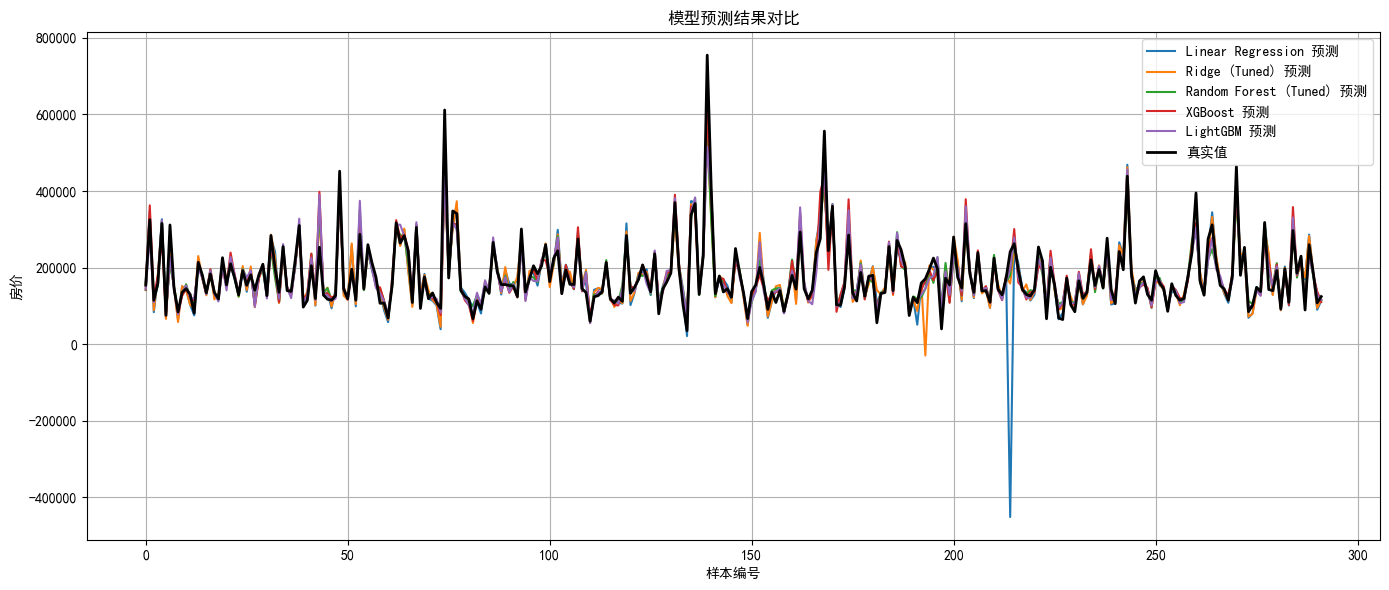

In [15]:
import matplotlib.pyplot as plt

# 设置中文字体显示
plt.rcParams['font.family'] = 'SimHei'  # 黑体支持中文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 可视化函数
def plot_predictions(y_true, y_preds, model_names, title='模型预测结果对比'):
    plt.figure(figsize=(14, 6))
    for pred, name in zip(y_preds, model_names):
        plt.plot(pred, label=f'{name} 预测')
    plt.plot(y_true.values, label='真实值', color='black', linewidth=2)
    plt.title(title)
    plt.xlabel('样本编号')
    plt.ylabel('房价')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 所有模型的预测结果与名称
predictions = [lr_pred, ridge_pred, rf_pred, xgb_pred, lgb_pred]
model_names = ['Linear Regression', 'Ridge (Tuned)', 'Random Forest (Tuned)', 'XGBoost', 'LightGBM']

# 调用可视化函数
plot_predictions(y_val, predictions, model_names)


C:\Users\A\AppData\Local\Temp\ipykernel_8016\3402816216.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=15)


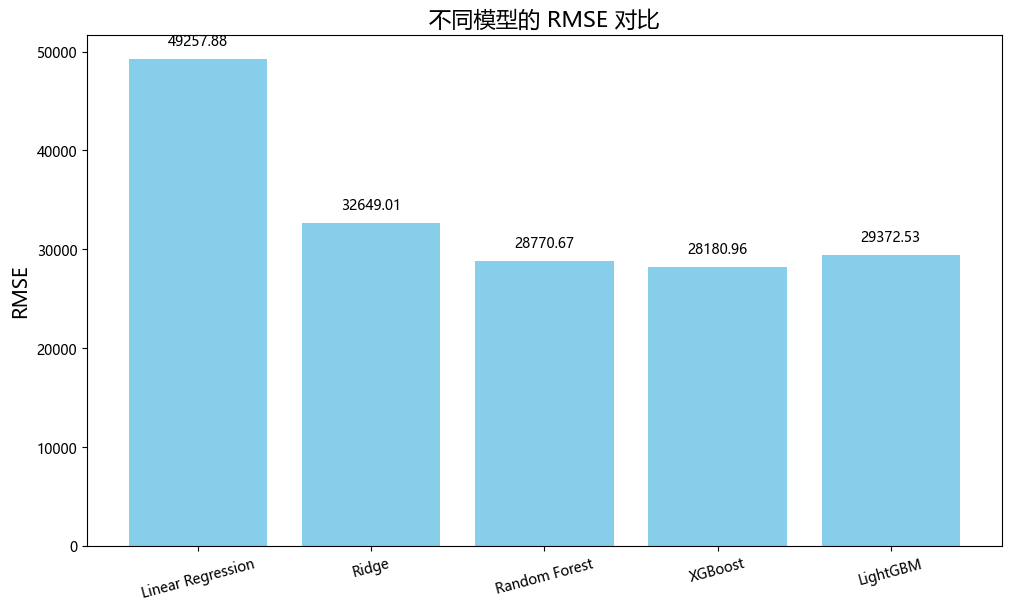

C:\Users\A\AppData\Local\Temp\ipykernel_8016\3402816216.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=15)


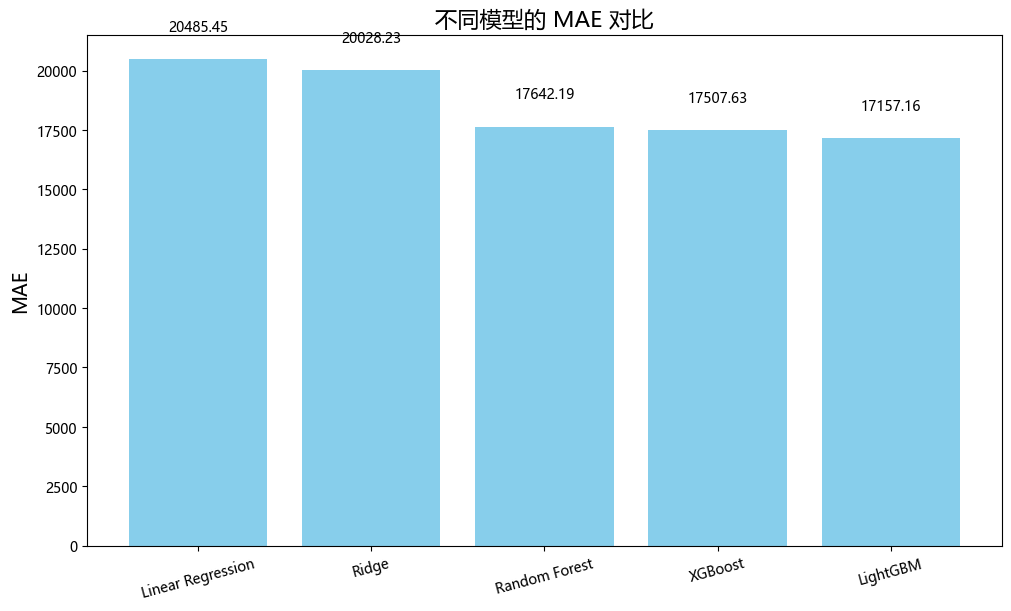

In [16]:
import matplotlib.pyplot as plt

# 设置中文字体和负号显示
plt.rcParams['font.family'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

model_names = ['Linear Regression', 'Ridge', 'Random Forest', 'XGBoost', 'LightGBM']
rmses = [49257.88, 32649.01, 28770.67, 28180.96, 29372.53]
maes = [20485.45, 20028.23, 17642.19, 17507.63, 17157.16]

def plot_bar_chart(values, title, ylabel):
    fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
    bars = ax.bar(model_names, values, color='skyblue')
    ax.set_title(title, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xticklabels(model_names, rotation=15)

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 1000, f'{yval:.2f}', ha='center', va='bottom')

    plt.show()

plot_bar_chart(rmses, '不同模型的 RMSE 对比', 'RMSE')
plot_bar_chart(maes, '不同模型的 MAE 对比', 'MAE')



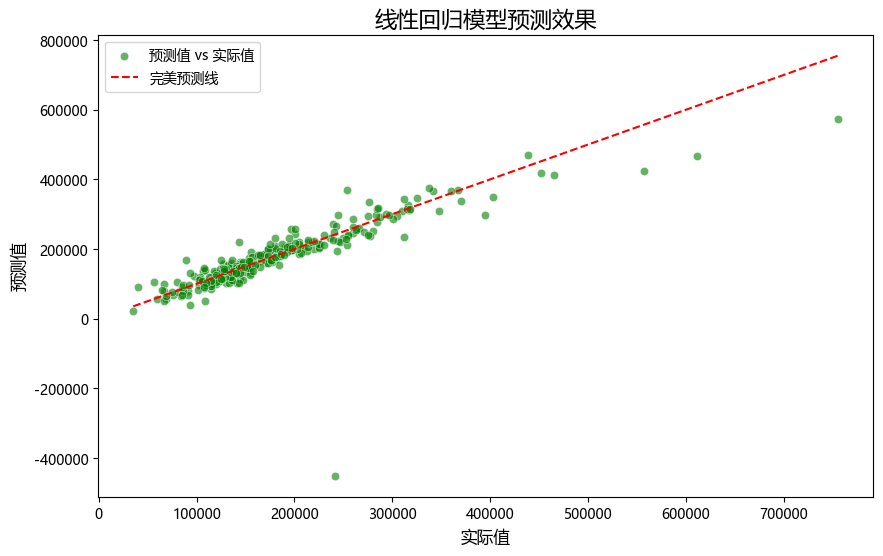

In [17]:
# 可视化实际值与预测值的对比 - 线性回归
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val, y=lr_pred, color='green', alpha=0.6, label="预测值 vs 实际值")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label="完美预测线")
plt.title("线性回归模型预测效果", fontsize=16)
plt.xlabel("实际值", fontsize=12)
plt.ylabel("预测值", fontsize=12)
plt.legend()
plt.show()


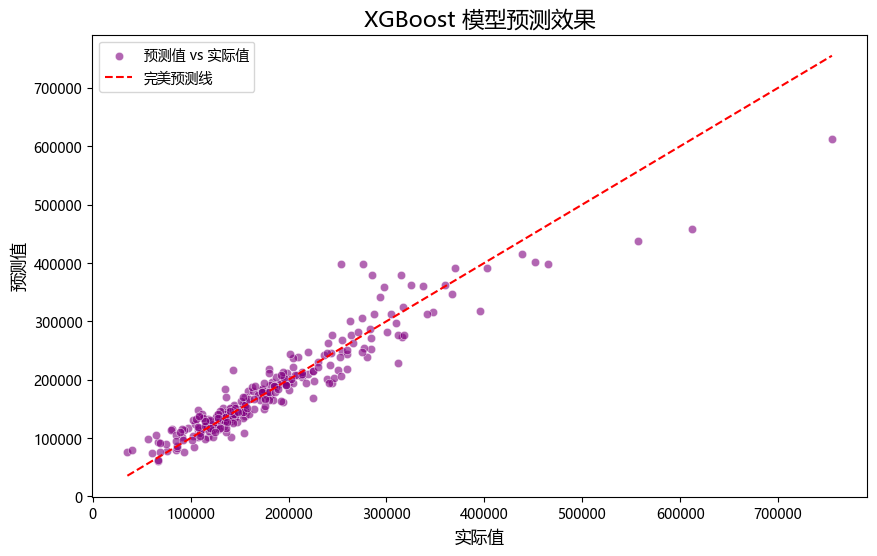

In [18]:
import seaborn as sns


# 可视化实际值与预测值的对比 - XGBoost
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val, y=xgb_pred, color='purple', alpha=0.6, label="预测值 vs 实际值")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label="完美预测线")
plt.title("XGBoost 模型预测效果", fontsize=16)
plt.xlabel("实际值", fontsize=12)
plt.ylabel("预测值", fontsize=12)
plt.legend()
plt.show()


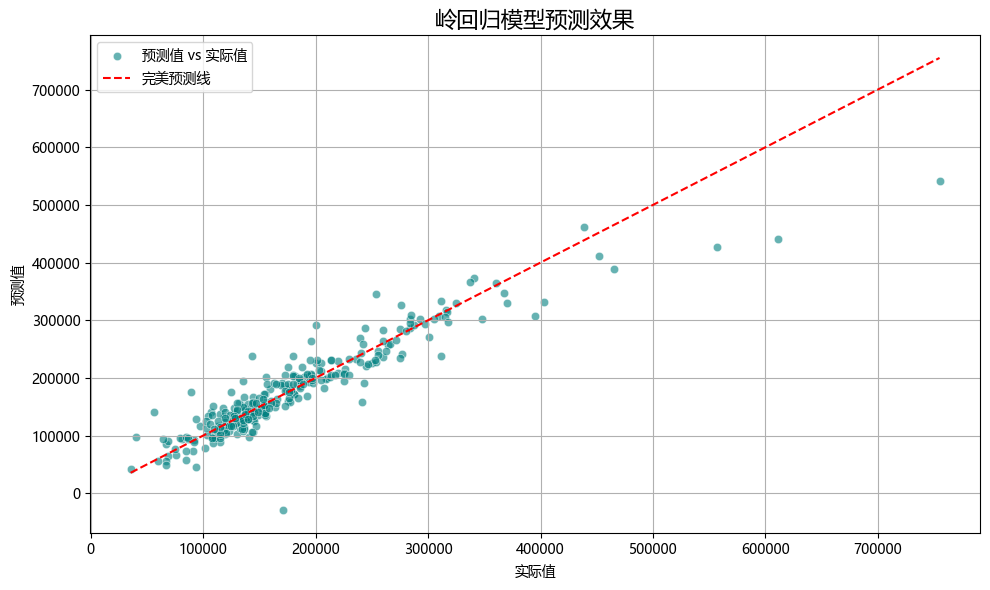

In [19]:
# 可视化实际值与预测值的对比 - 岭回归
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val, y=ridge_pred, color='teal', alpha=0.6, label="预测值 vs 实际值")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label="完美预测线")
plt.title("岭回归模型预测效果", fontsize=16)
plt.xlabel("实际值")
plt.ylabel("预测值")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


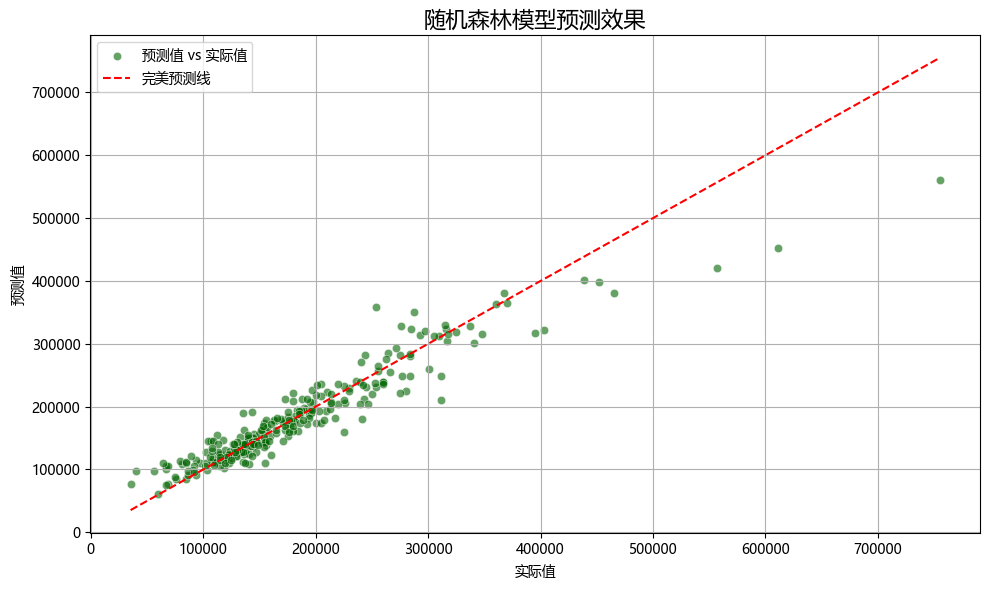

In [20]:
# 可视化实际值与预测值的对比 - 随机森林
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val, y=rf_pred, color='darkgreen', alpha=0.6, label="预测值 vs 实际值")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label="完美预测线")
plt.title("随机森林模型预测效果", fontsize=16)
plt.xlabel("实际值")
plt.ylabel("预测值")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


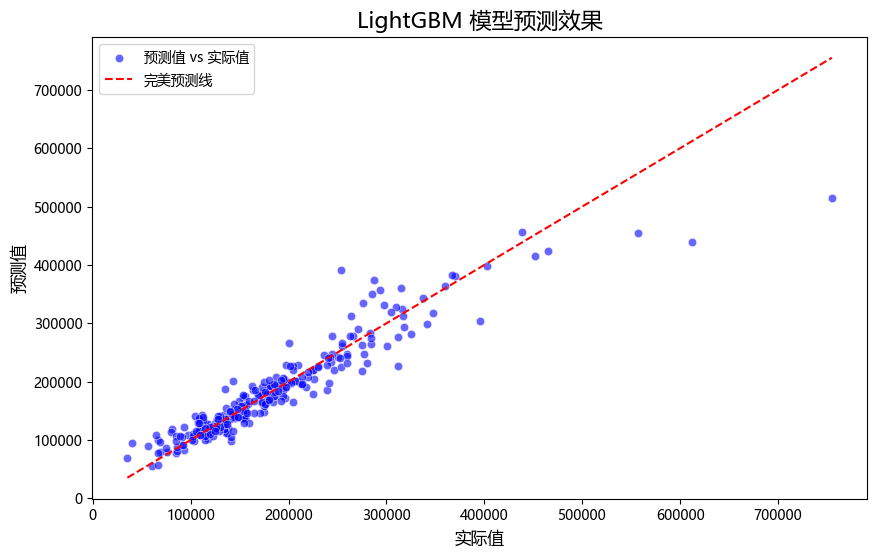

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# 可视化实际值与预测值的对比 - LightGBM
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val, y=lgb_pred, color='blue', alpha=0.6, label="预测值 vs 实际值")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label="完美预测线")
plt.title("LightGBM 模型预测效果", fontsize=16)
plt.xlabel("实际值", fontsize=12)
plt.ylabel("预测值", fontsize=12)
plt.legend()
plt.show()


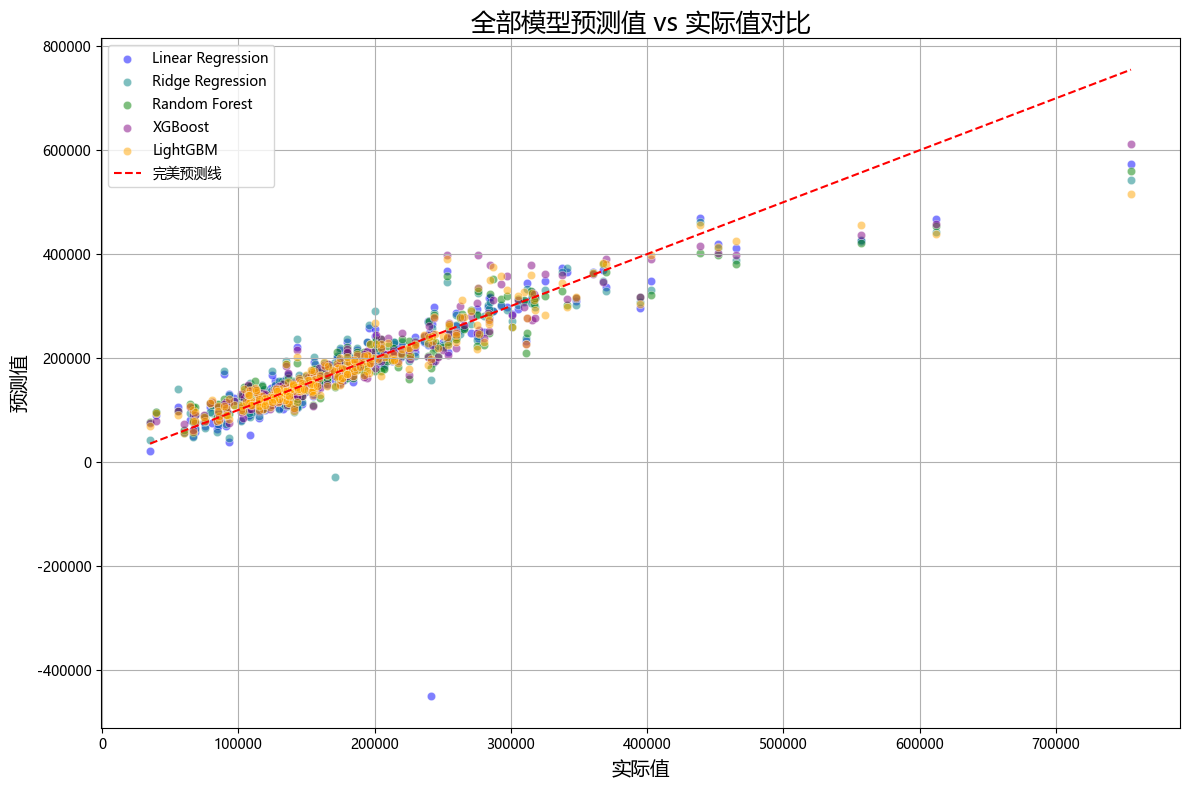

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

# 每个模型画一个散点
sns.scatterplot(x=y_val, y=lr_pred, color='blue', label='Linear Regression', alpha=0.5)
sns.scatterplot(x=y_val, y=ridge_pred, color='teal', label='Ridge Regression', alpha=0.5)
sns.scatterplot(x=y_val, y=rf_pred, color='green', label='Random Forest', alpha=0.5)
sns.scatterplot(x=y_val, y=xgb_pred, color='purple', label='XGBoost', alpha=0.5)
sns.scatterplot(x=y_val, y=lgb_pred, color='orange', label='LightGBM', alpha=0.5)

# 理想预测线
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label='完美预测线')

# 图形修饰
plt.title("全部模型预测值 vs 实际值对比", fontsize=18)
plt.xlabel("实际值", fontsize=14)
plt.ylabel("预测值", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
